# 利用机器学习进行手写字体识别的过程解析


## 概述

本课程作为之数字识别主题教程的第一节课。
在这个主题课程里，我们不光用到了opencv还用到了python的一个机器学习的库**sklearn**, 虽说opencv自带机器学习的API，但是对于阿凯来讲sklearn用着毕竟顺手一些。

在本节课，旨在给大家一个关于**机器学习流程**的宏观印象。不需要注重算法底层细节，只需走马观花看个大概。


## 引入依赖

In [1]:
import cv2
import numpy as np
from sklearn import datasets,svm
from matplotlib import pyplot as plt

## 数据预处理


**数据预处理是整个机器学习过程中， 耗费最大时间跟精力的地方， 大概会占据你80%以上的工作量。**


就拿数字识别来讲，数据预处理所需要做的事情如下：

* **去除背景** 是将带有背景的数字提取出来。也有可能需要自己手动抠。
* **图像变换** 纸张可能会有畸变，需要对其进行投影变换。或者2D仿射变换，旋转等。
* **图像滤波** 可能会有噪声，图像中夹杂者一些小噪点。需要进行一些数学形态学运算。
* **字符分割** 数字与数字之间可能有重叠，也由可能有连接，数据预处理需要将两者分开。
* **图像二值化** 
* **样本标注与配比** 每种数字各选多少个，而且要注意书写风格尽可能不能一样。标注图片与数字之间的对应关系。


**字符分割是整个图像预处理中最难的地方** 
![Screenshot_20180301_154627.png](./image/Screenshot_20180301_154627.png)

在课程的后半部分，我会介绍几个经典的字符分割的算法，但是不在此展开。


我们还是从简单一些的样例开始。

我们在的 **CH5.3 图像2D仿射变换** 这一节中教给大家如何从画布中提取数字区域。

![number_minarearect_canvas2.png](./image/number_minarearect_canvas2.png)

并最终放缩到统一尺寸，如下图所示。

![Screenshot_20180219_171151.png](./image/Screenshot_20180219_171151.png)



## 特征提取

特征，也称之为描述子，可以代表一个对象的标签。
例如描述一个人，我们可以采用这些描述子： 身高，体重，生日....
随着描述子数据量的增大，后续的计算量也就会很大，一般来讲需要的样本量也会很大。

所以，如何用少量的信息，描述原来数据的大部分特征，这个就是特征提取所要做的事情。 当然数据量的减少，必然带来信息的丢失。

3维空间的实物，可以拍成1000×1000像素的照片，通过照片我们可以判断这是个什么物体，而不需要输入整体的三维数据。（**降维**）

可能因为内容简单， 转换为8×8的图片你也能看出来这是个啥(**缩放** )，接下来还可能用5个数值或者更少的数值代表这个8×8的矩阵（**PCA主成分分析**， 抓大放小）

也可以将这个8×8的图片，变成一个长度为64的1维向量。本次演示中，就是这么做的。



[  7.5     15.9375  15.9375  15.9375  15.9375  15.9375  15.9375  15.9375
  14.25    15.9375  15.9375  15.9375  15.9375  15.9375  15.9375  15.9375
   0.       0.       0.       1.      15.9375  15.9375  15.9375   4.8125
   0.       0.       1.3125  15.9375  15.9375  15.9375   0.       0.       0.
   0.       3.      15.9375  15.9375   3.       0.       0.       0.       0.
  15.9375  15.9375  15.9375   0.       0.       0.       0.       0.
  15.9375  15.9375   3.8125   0.       0.       0.       0.       4.9375
  15.9375  15.       0.0625   0.       0.       0.    ]


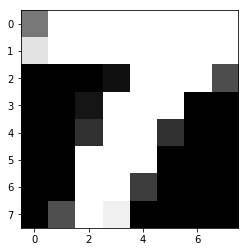

In [2]:
# 数据可视化， 将向量重新变回图片
# 利用matplotlib

def showDigit(vector):
    # 重新变形
    img = vector.reshape((8, 8))
    plt.imshow(img, cmap='gray')
    plt.show()

def cvtImg2Vect(img):
    # 将灰度图变为向量
    # 变换为 8×8
    img = cv2.resize(img, (8,8), interpolation = cv2.INTER_LINEAR)
    # 变为向量 并将数值放缩在 0-16之间
    return np.reshape(img, (64)) / 16

# 读入样例图片
demo_digit_img = cv2.imread('./number_bin/7.png', cv2.IMREAD_GRAYSCALE)
demo_digit_vect = cvtImg2Vect(demo_digit_img)

# 提取好的向量 data
print(demo_digit_vect)
showDigit(demo_digit_vect)


## 数据标注

给每个特征进行分类，并添加标记，标注其对应的分类。必须要一一对应。


## 读入数据

为了做数字识别你需要做大量的图片，图像预处理，然后标注。
好在sklearn中有一个预设的手写数字的数据库，里面有1797个手写数字，所以我们用sklearn中自带的数据库进行模型训练。


In [3]:
# 读入手写字体的
digits = datasets.load_digits()

In [4]:
# 载入数据 data
data = digits.data
# 载入标签 label
target = digits.target

In [5]:
# 打印数据
data

array([[  0.,   0.,   5., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,  10.,   0.,   0.],
       [  0.,   0.,   0., ...,  16.,   9.,   0.],
       ..., 
       [  0.,   0.,   1., ...,   6.,   0.,   0.],
       [  0.,   0.,   2., ...,  12.,   0.,   0.],
       [  0.,   0.,  10., ...,  12.,   1.,   0.]])

In [6]:
# 打印第一行数据 长度为64
data[0] 

array([  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.,   0.,   0.,  13.,
        15.,  10.,  15.,   5.,   0.,   0.,   3.,  15.,   2.,   0.,  11.,
         8.,   0.,   0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.,   0.,
         5.,   8.,   0.,   0.,   9.,   8.,   0.,   0.,   4.,  11.,   0.,
         1.,  12.,   7.,   0.,   0.,   2.,  14.,   5.,  10.,  12.,   0.,
         0.,   0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.])

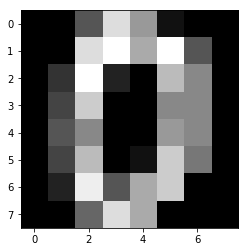

In [7]:
showDigit(data[0])

In [8]:
# 打印标签 label
target

array([0, 1, 2, ..., 8, 9, 8])

## 分割数据集

将数据分为训练集跟测试集。训练集用于训练SVM模型,测试集用于检验SVM模型的准确率。


In [9]:
# 查看一共有多少个sample
n_digit = len(data)
print(n_digit)

1797


对原来的数据进行重排序， 随机打乱

In [10]:
idxs = np.array(range(n_digit))
idxs

array([   0,    1,    2, ..., 1794, 1795, 1796])

In [11]:
# 利用shuffle 对索引序列进行重新排序
np.random.shuffle(idxs)
idxs

array([1690, 1667,  346, ...,  222, 1066,  374])

In [12]:
# 利用numpy的索引进行重新排序
data = data[idxs]
target = target[idxs]

# 分割训练集跟测试集
# 获取训练集
n_train = int(n_digit*0.80) # 取前80%作为训练集
train_digit = data[:n_train]
train_label = target[:n_train]

# 获取测试集
n_test = n_digit - n_train # 测试样本的个数
test_digit = data[n_train:] # 测试样本的特征
test_label = target[n_train:] # 测试样本的标签

## 选择机器学习模型

根据经验选择机器学习模型， 这里我们选择的是SVM 支持向量机
目前为止，你不需要知道SVM的具体算法，只需要将其当作黑箱，喂养给这个模型很多好吃的（数据）， 他就会越来越聪明，提高分类的准确率。

## 训练模型

In [13]:
# 创建一个分类器，类型为SVM 支持向量机
# 并定义超参数 gamma=0.001
classifier = svm.SVC(gamma=0.001)

In [14]:
# 开始fit
# 输入训练集， 调参
classifier.fit(train_digit, train_label)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## 模型预测

将样本输入训练好的模型， 模型会给出自己的预测结果

In [15]:
# 获取样本输入
sample_digit_vect = test_digit[0]
# 获取真实的标签 （已知）
sample_digit_label = test_label[0]

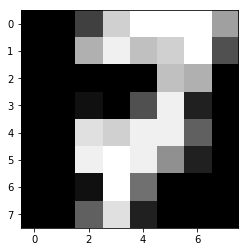

In [16]:
showDigit(sample_digit_vect)

In [17]:
print("正确标签 ： {}".format(sample_digit_label))

正确标签 ： 7


In [18]:
# 利用模型预测
classifier.predict([sample_digit_vect])

array([7])

In [19]:
sample_digit_predict = classifier.predict([sample_digit_vect])[0]
# 判断是否准确
sample_digit_predict == sample_digit_label

True

**预测我们自己预处理的样本数据**

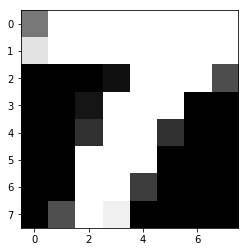

In [20]:
showDigit(demo_digit_vect)

In [21]:
# 预测我们自己预处理的样本数据
classifier.predict([demo_digit_vect])

array([7])

## 模型评估

模型评估就是用来说明一个机器学习模型效果的好坏，准不准，需要借助某种指标或者说是度量．

最简单的指标莫过于**准确率 Accuracy**了，　准确率＝成功匹配的个数 / 测试集总个数

In [22]:
# 将训练集传入classifier
test_predict = classifier.predict(test_digit)
# 打印预测结果
test_predict[:10]

array([7, 7, 7, 3, 2, 0, 4, 5, 8, 1])

In [23]:
# 将真实的标签与预测标签对比， 获取布尔值
result = test_predict == test_label
result[:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [24]:
# 统计为真的个数
n_match = np.count_nonzero(result)
n_match

356

In [25]:
# 获取准确率  成功匹配的个数 / 测试集总个数
accuracy = n_match / n_test

print("Accuracy 准确率为：%.4f"%accuracy)

Accuracy 准确率为：0.9889


PS 不过，大家千万也别特别痴迷在准确率上，因为这样容易过拟合．
在后续的教程里，阿凯会举例说明**过拟合**跟**欠拟合**的概念．

## 模型持久化
训练好的模型，为了方便我们下次再次调用，需要将**分类器　classifier**对象持久化为二进制数据．
下次使用的时候，直接导入模型，而不至于再重新训练模型．


In [26]:
import pickle

# 将分类器 classfier 序列化为二进制数据
clf_bin = pickle.dumps(classifier)

In [27]:
# 将二进制数据 存入文件中
with open('digit_clf.bin','bw') as f:
    f.write(clf_bin)


In [28]:
# 从文件中重新读入序列化的二进制数据
clf_bin2 = None
with open('digit_clf.bin','br') as f:
    clf_bin2 = f.read()
# 将二进制数据还原为分类器对象
classifier2 = pickle.loads(clf_bin2)

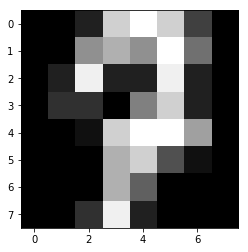

In [29]:
# 测试用分类器重新进行分类

dight_vect = test_digit[1]
showDigit(dight_vect)

In [30]:
# 预测样本
classifier2.predict([dight_vect])

array([7])